# Comparison of different models for image matching
Mount the shared google drive folder and read the filenames of the gallery and probe images

In [21]:
import pandas as pd
from scipy.spatial.distance import cdist
import numpy as np
import glob
import cv2
from matplotlib import pyplot as plt
from time import time

from google.colab import drive
drive.mount('/content/drive')

hiero_dataset_path = '/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/'

df = pd.read_csv(hiero_dataset_path+'groundtruth.csv', sep=';',header=None)
gt = np.array(df)

gallery_names = [f for f in sorted(glob.glob(hiero_dataset_path+'hiero_01/*.png'))]
query_names = [f for f in sorted(glob.glob(hiero_dataset_path+'hiero_02/*.png'))]

if len(gallery_names)>0:
  for name in gallery_names:
    print(name)
else:
  print('Error!\nIt seems that the content of the shared drive cannot be accessed.')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/01.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/02.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/03.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/04.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/05.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/06.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/07.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/08.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/09.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/10.png
/content/drive/Shareddrives/ImageVideoAnalysis/Datasets/Hiero/hiero_01/11.png
/content/driv

## Image matching based on the Hausdorff distance


In [ ]:

def hausdorff(coords_01, coords_02): # implementa distanza coppie coordinate
    dist_matrix = cdist(coords_01, coords_02)
    #h1 = np.max(np.min(dist_matrix, axis=0))
    #h2 = np.max(np.min(dist_matrix, axis=1))
    h1 = np.mean(np.min(dist_matrix, axis=0)) # calcolo il valore medio della distanza di un punto di un insieme A dal più vicino in un insieme B invece che la max
    h2 = np.mean(np.min(dist_matrix, axis=1)) # non è veloce quanto max, ma più accurato
    if h1>h2:
        return(h1)
    return(h2)
    
def normalize_coordinates(coords):
    coords = coords - np.mean(coords, axis=0)
    std = np.std(coords, axis=0)
    coords = coords / std[1]
    return(coords)

time_start = time()

# Initialize the distance_matrix
dist_matrix = np.zeros([len(query_names),len(gallery_names)])

for kq, query_name in enumerate(query_names):
    img_query = cv2.imread(query_name, 0)
    # Convert the query bitmax into coordinates
    # of foreground pixels
    coords_query = np.argwhere( img_query == 0 )
    # Normalize (translate and scale) the coordinates
    coords_query = normalize_coordinates(coords_query)

    for kg, gallery_name in enumerate(gallery_names):
        img_gallery = cv2.imread(gallery_name, 0)
        # Convert the gallery bitmax into coordinates
        # of foreground pixels
        coords_gallery = np.argwhere( img_gallery == 0 )
        # Normalize (translate and scale) the coordinates
        coords_gallery = normalize_coordinates(coords_gallery)

        # Compute the distance between the query and the gallery
        dist_matrix[kq, kg] = hausdorff(coords_query, coords_gallery)

# For each query hieroglyph find the index of the closest
# gallery hieroglyph 
pairs = np.argmin(dist_matrix, axis=1)
match_index = np.argmin(dist_matrix, axis=1)
gt_index = np.argmax(gt, axis=1)

time_end = time()

# Display matched pairs
display = False
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')



Matched hieroglyphs: 15 out of 19
Processing time:  1.354701280593872 sec


## Image matching based on PCA

(4096, 22)


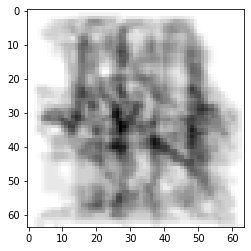

Computing eigenvalues and eigenvectors...
...done!
(4096, 19)
(19, 22)
Matched hieroglyphs: 15 out of 19
Processing time:  0.6846401691436768 sec


In [45]:
low_dim_trick = True
global bitmap_size
bitmap_size = 64
K = 22 # Dimension of the PCA reduced space # influenza esecuzione, con la pca si calcola una nuova base nello spazio delle features (64x64) e poi si prendeono solo i primi autovettori, si proiettano i dati in un sottospazio determinato dai primi K autovettori,questi K dice qual è la dim del sottospazio in cui penso di preservare la struttura dei dati, variarlo

def convert_to_square_bitmap(img):
    thumbnail = np.ones([bitmap_size, bitmap_size]).astype('uint8') * np.max(img)

    if img.shape[0] > img.shape[1]:
        #Image height is higher than its width
        scale_f = bitmap_size / float(img.shape[0])
        dest_size = (int(img.shape[1] * scale_f), bitmap_size)
        #print(dest_size)
        scaled_img = cv2.resize(img, dest_size)
        delta = int((bitmap_size - scaled_img.shape[1])/2)
        thumbnail[:, delta:delta+scaled_img.shape[1]] = scaled_img
    else:
        #Image height is lower than its width
        scale_f = bitmap_size / float(img.shape[1])
        dest_size = (bitmap_size, int(img.shape[0] * scale_f))
        #print(dest_size)
        scaled_img = cv2.resize(img, dest_size)
        delta = int((bitmap_size - scaled_img.shape[0])/2)
        thumbnail[delta:delta+scaled_img.shape[0], :] = scaled_img
#    plt.imshow(thumbnail, cmap='gray')
#    plt.show()
    return(thumbnail)

time_start = time()

for kg, gallery_name in enumerate(gallery_names):
    img_gallery = cv2.imread(gallery_name, 0)
    thmb = convert_to_square_bitmap(img_gallery)
    if kg == 0:
        H = thmb.reshape(-1)
    else:
        H = np.vstack( (H, thmb.reshape(-1)) )
H = H.T # Now H has 4096 rows and as many columns as the number of gallery hiero
gallery_mean = np.mean(H, axis=1).reshape(-1,1)
H = H - gallery_mean
print(H.shape)
plt.imshow(gallery_mean.reshape(bitmap_size,-1), cmap='gray')
plt.show()

print('Computing eigenvalues and eigenvectors...')
if low_dim_trick:
    e_vals_g, e_vect_g = np.linalg.eig(np.matmul(H.T, H))
else:
    e_vals_g, e_vect_g = np.linalg.eig(np.matmul(H, H.T))
e_vals_g = np.real(e_vals_g)
e_vect_g = np.real(e_vect_g)
print('...done!')

idx = e_vals_g.argsort()[::-1]

for k in np.arange(K):
    if low_dim_trick:
        v = np.matmul(H, e_vect_g[:,idx[k]].reshape(-1,1))
    else:
        v = e_vect_g[:,idx[k]]

    v = v / np.linalg.norm(v)
    if k == 0:
        base_m = v.reshape(1,-1)
    else:
        base_m = np.vstack( (base_m, v.reshape(1,-1)) )
remapped_g = np.matmul( base_m, H )

for kq, query_name in enumerate(query_names):
    img_query = cv2.imread(query_name, 0)
    thmb = convert_to_square_bitmap(img_query)
    if kq == 0:
        H = thmb.reshape(-1)
    else:
        H = np.vstack( (H, thmb.reshape(-1)) )
H = H.T # Now H has 4096 rows and as many columns as the number of query hiero
print(H.shape)

# Center the data using the mean gallery vector 
H = H - gallery_mean
#Compute coordinates of the query vectors in the new space
remapped_q = np.matmul( base_m, H )

# Compute the distance of remapper query hiero to remapped gallery hiero
dist_matrix = cdist(remapped_q.T, remapped_g.T, metric='cosine')
print(dist_matrix.shape)

# For each query hieroglyph find the index of the closest
# gallery hieroglyph 
pairs = np.argmin(dist_matrix, axis=1)

time_end=time()

# Display matched pairs
display = False
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')




## Image matching based on template matching



In [64]:
# qui è nel dominio dello spazio, ci dsono diversi score che posso utilizzare, sono scelti in cv2.match template nel for k1
# nel fare il template matching c'è un gioco simile al blockstride, faccio scivolare i template sull'immagine e calcolo il coeff.
# questo scorrimento è a passo 1
# posso fare avanzare il template a un passo discreto

bitmap_size = 128 
pad_size = 32
foreground_pixel_value = 0

def fit_and_center(img, target_size, fg_val):
    rows = img.shape[0]
    cols = img.shape[1]

    if fg_val==0:
        img_out = np.ones([target_size,target_size])*255
    else:
        img_out = np.zeros([target_size,target_size])

    if rows>cols:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(rows),
                             fy=target_size/np.float32(rows))
        delta = np.uint16( (target_size - tmp_img.shape[1])/2.0 )
        img_out[:, delta:delta+tmp_img.shape[1]] = tmp_img
    else:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(cols),
                             fy=target_size/np.float32(cols))
        delta = np.uint16( (target_size - tmp_img.shape[0])/2.0 )
        img_out[delta:delta+tmp_img.shape[0],:] = tmp_img

    return (255 - img_out)

time_start = time()

# Read gallery images and compute the FFT
for kg, gallery_name in enumerate(gallery_names):
    tmp_img = fit_and_center(cv2.imread(gallery_name, 0), bitmap_size, foreground_pixel_value)
#    plt.imshow(tmp_img, cmap='gray')
#    plt.show()
    thmb = tmp_img.copy()
    if kg == 0:
        IMG_gallery = thmb.reshape(-1)
    else:
        IMG_gallery = np.vstack( (IMG_gallery, thmb.reshape(-1)) )

# Read query images and compute the FFT
for kg, query_name in enumerate(query_names):
    tmp_img = fit_and_center(cv2.imread(query_name, 0), bitmap_size, foreground_pixel_value)
#    plt.imshow(tmp_img, cmap='gray')
#    plt.show()
    thmb = tmp_img.copy()
    if kg == 0:
        IMG_query = thmb.reshape(-1)
    else:
        IMG_query = np.vstack( (IMG_query, thmb.reshape(-1)) )

d_mat = np.zeros([len(query_names), len(gallery_names)])
# Compute the distance matrix
for k2 in np.arange(len(gallery_names)):
    img_g = IMG_gallery[k2].reshape(bitmap_size, bitmap_size)
    #Pad the gallery image to allow the query to slightly shift horizontally and vertically # estende ecorndice immagine, anche quando il template esce fuori dal bordo dell'immagine
    img_g = cv2.copyMakeBorder(img_g, pad_size, pad_size, pad_size, pad_size,
                               cv2.BORDER_REPLICATE)
    for k1 in np.arange(len(query_names)):
        img_q = (IMG_query[k1].reshape(bitmap_size, bitmap_size))
        tmp = cv2.matchTemplate(img_g.astype('uint8'),img_q.astype('uint8'),
                                cv2.TM_SQDIFF_NORMED) # coeff. cross correlazione normalizzato, se faccio un help posso modificare, come ultimo parametro, non tutti operano nello stesso modo
        d_mat[k1,k2] = 1.0/( 1.0+np.max(tmp) )

time_end = time()
        
match_index = np.argmin(d_mat, axis=1)

gt_index = np.argmax(gt, axis=1)

# Display matched pairs
display = False
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')



Matched hieroglyphs: 1 out of 19
Processing time:  0.7449951171875 sec


## Image matching based on template matching in the FFT domain

In [68]:
# nel dominio fft, anche qui cambiano cose
bitmap_size = 128

foreground_pixel_value = 0

def fit_and_center(img, target_size, fg_val):
    rows = img.shape[0]
    cols = img.shape[1]

    if fg_val==0:
        img_out = np.ones([target_size,target_size])*255
    else:
        img_out = np.zeros([target_size,target_size])

    if rows>cols:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(rows),
                             fy=target_size/np.float32(rows))
        delta = np.uint16( (target_size - tmp_img.shape[1])/2.0 )
        img_out[:, delta:delta+tmp_img.shape[1]] = tmp_img
    else:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(cols),
                             fy=target_size/np.float32(cols))
        delta = np.uint16( (target_size - tmp_img.shape[0])/2.0 )
        img_out[delta:delta+tmp_img.shape[0],:] = tmp_img

    return (255 - img_out)

time_start = time()

# Read gallery images and compute the FFT
for kg, gallery_name in enumerate(gallery_names):
    tmp_img = fit_and_center(cv2.imread(gallery_name, 0), bitmap_size, foreground_pixel_value)
    thmb = np.fft.fft2(tmp_img)
    if kg == 0:
        FFT_gallery = thmb.reshape(-1)
    else:
        FFT_gallery = np.vstack( (FFT_gallery, thmb.reshape(-1)) )

# Read query images and compute the FFT
for kg, query_name in enumerate(query_names):
    tmp_img = fit_and_center(cv2.imread(query_name, 0), bitmap_size, foreground_pixel_value)
    thmb = np.fft.fft2(tmp_img)
    if kg == 0:
        FFT_query = thmb.reshape(-1)
    else:
        FFT_query = np.vstack( (FFT_query, thmb.reshape(-1)) )

d_mat = np.zeros([len(query_names), len(gallery_names)])
# Compute the distance matrix
for k1 in np.arange(len(query_names)):
    FFT_q = np.conj(FFT_query[k1].reshape(bitmap_size, bitmap_size))
    for k2 in np.arange(len(gallery_names)):
        FFT_g = FFT_gallery[k2].reshape(bitmap_size, bitmap_size)
        tmp = np.abs(np.fft.ifft2(FFT_q*FFT_g))
        d_mat[k1,k2] = 1.0/( 1.0+np.max(tmp) )

time_end = time()
        
match_index = np.argmin(d_mat, axis=1)

gt_index = np.argmax(gt, axis=1)

# Display matched pairs
display = False
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')



Matched hieroglyphs: 9 out of 19
Processing time:  0.18634557723999023 sec


## Image matching based on geometric moments

In [81]:
# momenti geometrici, spaziali
# momenti descrivono un oggetto, una regione con un vettore di features, suponiamo momemtni cartesiano siano 10 features, componenti
# supponiamo che la prima componente m00 (numero pixel regione) vari da 300 a 500 [k1=0 k2=10] il momento m10 m01 è il valore medio, in una bitmap 64x64 è 32
# quindi se una componente ha valori che variano tra le centinaia, le seconda ha un range più piccolo, se ne calcoliamo le distanza euclidea succedee che la componente che ha un range più grande, se è più grande, ssarà quella che determinerà la distanza euclidea, è come se la secondoa features non ci fosse
# per evitare cge questo succede si fa uno scheming delle features, ogni features viene diviso per un fattore, per normalizzarla, in modo da riportarla a un range costanzaìte
# *

# indicizzazione: se devo cercare se una query corrisponde a un oggeto della gallery, evita di confrontare la query con ognuna delle immagini della gallery
# alcune tecninche si prestano bene per l'indicizzazione
# dire se aumentiamo cosa, coas succede
# bins ++ accuratezza --


def fit_and_center(img, target_size, fg_val):
    rows = img.shape[0]
    cols = img.shape[1]

    if fg_val==0:
        img_out = np.ones([target_size,target_size])*255
    else:
        img_out = np.zeros([target_size,target_size])


    if rows>cols:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(rows), fy=target_size/np.float32(rows))
        delta = np.uint16( (target_size - tmp_img.shape[1])/2.0 )
        #print(img.shape, delta, tmp_img.shape)
        img_out[:, delta:delta+tmp_img.shape[1]] = tmp_img
    else:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(cols), fy=target_size/np.float32(cols))
        delta = np.uint16( (target_size - tmp_img.shape[0])/2.0 )
        #print(img.shape, delta, tmp_img.shape)
        img_out[delta:delta+tmp_img.shape[0],:] = tmp_img

    return (255 - img_out)

time_start = time()

# Read gallery images and compute moments
for kg, gallery_name in enumerate(gallery_names):
    tmp_img = fit_and_center(cv2.imread(gallery_name, 0), bitmap_size, foreground_pixel_value)
#    plt.imshow(tmp_img, cmap='gray')
#    plt.show()
    thmb = np.array(list(cv2.moments(tmp_img, binaryImage=True).values()))
    if kg == 0:
        M_gallery = thmb.reshape(-1)
    else:
        M_gallery = np.vstack( (M_gallery, thmb.reshape(-1)) )

# Read query images and compute moments
for kg, query_name in enumerate(query_names):
    tmp_img = fit_and_center(cv2.imread(query_name, 0), bitmap_size, foreground_pixel_value)
#    plt.imshow(tmp_img, cmap='gray')
#    plt.show()
    thmb = np.array(list(cv2.moments(tmp_img, binaryImage=True).values()))
    if kg == 0:
        M_query = thmb.reshape(-1)
    else:
        M_query = np.vstack( (M_query, thmb.reshape(-1)) )

#Compute scaled features (zero mean and unitary STD)
# scalatura dellle featuers, data una variabile calcolo la media, la levo, poi calcolo la varizna e divido la variabile per la deviazione standard, variabili media nulla e varizna std 1
M = np.vstack( (M_query, M_gallery) )
avg=np.average(M, axis=0)
std= np.std(M-avg, axis=0)
M_q_scaled = (M_query - avg)/std
M_g_scaled = (M_gallery - avg)/std
# Retain only the moments from k1 to k2
# Spatial moments from index 0 to 9
# Central moments from index 10 to 16
# Normalized moments from index 17 to 23

k1 = 10 #consentono di selezionare descrittore momenti calcolati da cv2, operano sulla maschera di regione di interessa, calcola tutti i momenti, centrali, spaziali e normalizzati
k2 = 17 # per esempio in questa configurazione, quali mommenti sto utilizzando? i normalizzati

# prezzo che pago: quel descrittore è meno robusto del descrittore annalogo che non implementa la invarianza di rotazione
# rispetto a un descrittore non invariante a rotazione, il descrittore che è invariante funziona certamente meglio se sono certamente identiche ma ruotate
# ma se non è così il descrittore invariante perde qualcosa, risultato se ho un contensto in cui onn mi serve una invarianza alla scala, usando un descrittore che è variante, fa perdere qualcosa
# quindi se non serve la varianza a rotazione, si perde qualcosa
# verifare quando scelta momenti spaziali, centrali, normalizzati quanto impatto hanno sul risultato

# Select scaled vs original features
d_mat = cdist(M_q_scaled[:, k1:k2], M_g_scaled[:, k1:k2], metric='euclidean') # *, fare prove qui, vedere cosa cambia
# nel calcolomatrice distanze, la funzione cdist usa una matricolare metrica, qui si considera cos angolo, si può scegliere metrica euclidea..
#d_mat = cdist(M_query[:, k1:k2], M_gallery[:, k1:k2], metric='cosine')
        
match_index = np.argmin(d_mat, axis=1)

gt_index = np.argmax(gt, axis=1)
time_end = time()

# Display matched pairs
display = False
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')


Matched hieroglyphs: 14 out of 19
Processing time:  0.19388079643249512 sec


## Image matching based on Histograms of Gradient Orientation

In [85]:
# i parametri da controllare sono quelli fino a padding

foreground_pixel_value = 0

bitmap_size = 128

# HoG descriptor parameters
winSize = (32,32)
blockSize = (16,16)
blockStride = (16,16) # di quanto scorro, se = blocsize all'interno di una finestra 32x32 estrarrò dei descrittori, il blocco successivo è shiftato di 16,,non ho sovrapposzine con blocco precedente
# avere un blocstride più basso si è più fini, svantaggi: per ogni blocco ho un istogramma nuovo che viene concatenato per calcolare istogramma della finestra, per effeto di cod all'aumentare delle dimensioni, la distnza rischia di essere meno discriminativa
cellSize = (8,8)
nbins = 64
winStride = (16,16)
padding = (0,0)

#img_histo_size = (target_img_size / winSize[0])**2 * nbins * blockSize[0] / cellSize[0]

def fit_and_center(img, target_size, fg_val):
    rows = img.shape[0]
    cols = img.shape[1]

    if fg_val==0:
        img_out = np.ones([target_size,target_size])*255
    else:
        img_out = np.zeros([target_size,target_size])


    if rows>cols:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(rows), fy=target_size/np.float32(rows))
        delta = np.uint16( (target_size - tmp_img.shape[1])/2.0 )
        #print(img.shape, delta, tmp_img.shape)
        img_out[:, delta:delta+tmp_img.shape[1]] = tmp_img
    else:
        tmp_img = cv2.resize(img, None, fx=target_size/np.float32(cols), fy=target_size/np.float32(cols))
        delta = np.uint16( (target_size - tmp_img.shape[0])/2.0 )
        #print(img.shape, delta, tmp_img.shape)
        img_out[delta:delta+tmp_img.shape[0],:] = tmp_img

    return img_out


time_start = time()

hog =cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

# Build the gallery HoGs
for kg, gallery_name in enumerate(gallery_names):
    tmp_img = fit_and_center(cv2.imread(gallery_name, 0), bitmap_size, foreground_pixel_value)
    thmb = np.array(hog.compute(np.uint8(tmp_img),winStride,padding))
    if kg == 0:
        HoG_gallery = thmb.reshape(-1)
    else:
        HoG_gallery = np.vstack( (HoG_gallery, thmb.reshape(-1)) )

# Build the query HoGs
for kq, query_name in enumerate(query_names):
    tmp_img = fit_and_center(cv2.imread(query_name, 0), bitmap_size, foreground_pixel_value)
    thmb = np.array(hog.compute(np.uint8(tmp_img),winStride,padding))
    if kq == 0:
        HoG_query = thmb.reshape(-1)
    else:
        HoG_query = np.vstack( (HoG_query, thmb.reshape(-1)) )

# Compute the distance matrix
d_mat = cdist(HoG_query, HoG_gallery, metric='cosine')

match_index = np.argmin(d_mat, axis=1)
gt_index = np.argmax(gt, axis=1)

time_end = time()

# Display matched pairs
display = False # se false evita di stampare tutte immagini, ci dà direttamente il risultato
matched = 0
for k in np.arange(len(query_names)):
  if gt[k,match_index[k]]==1:
    matched = matched + 1
  if display:
    img_qry = cv2.imread(query_names[k], 0)
    img_glr = cv2.imread(gallery_names[match_index[k]], 0)
    img_glr_true = cv2.imread(gallery_names[gt_index[k]], 0)
    plt.figure(k)
    plt.subplot(1,3,1)
    plt.imshow(img_qry, cmap='gray'), plt.title('Query')
    plt.subplot(1,3,2)
    plt.imshow(img_glr, cmap='gray'), plt.title('Best matched in gallery', fontsize=10)
    plt.subplot(1,3,3)
    plt.imshow(img_glr_true, cmap='gray'), plt.title('True match in gallery', fontsize=10)
    plt.show()

# Output the number of matched queries and the processing time
print('Matched hieroglyphs:', matched, 'out of', len(query_names))
print('Processing time: ', (time_end-time_start), 'sec')


Matched hieroglyphs: 19 out of 19
Processing time:  0.16605496406555176 sec
